# Ficheux 2020 single-qubit phases
In this tutorial we show how to ideally correct for single-qubit phases accumulated during the implementation of the CPHASE gate between two fluxonia using the Ficheux scheme. The notebook is adapted from the notebook Ficheux 2020.

In [8]:
import numpy as np
import sys
import time
import datetime
import qutip as qtp 
import cmath
import matplotlib.pyplot as plt
from scipy import constants
from scipy.optimize import minimize
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
from IPython.display import display, Latex
from itertools import product, combinations

The gate is based on the following driven Hamiltonian of two-capacitively coupled fluxonium qubits

$$\hat{H} = \hat{H}^{(0)}_A + \hat{H}^{(0)}_B + \hat{V} + \hat{H}_{drive}$$

$$\hat{H}^{(0)}_A = 4 E_{C,A} \cdot \hat{n}^2_A + \frac{1}{2}E_{L,A}\cdot\hat{\varphi}^2_A - E_{J,A}\cos\left(\hat{\varphi}_A - \phi_{ext,A}\right)$$

$$\hat{H}^{(0)}_B = 4 E_{C,B} \cdot \hat{n}^2_B + \frac{1}{2}E_{L,B}\cdot\hat{\varphi}^2_B - E_{J,B}\cos\left(\hat{\varphi}_B - \phi_{ext,B}\right)$$

$$\hat{V} = J_C \cdot \hat{n}_A \cdot \hat{n}_B$$

$$\frac{\hat{H}_{drive}}{h} = \left( \epsilon_A \hat{n}_A + \epsilon_B \hat{n}_B \right) \cos(2\pi f_d t)$$

Energy spectrum :
![](energy_levels.jpg)

# Single fluxonia
We take parameters as in Table 1 of the paper. 

In [9]:
# Values in GHz (divided by h)
#Fluxonium A
ec_a = .973
el_a = .457
ej_a = 5.899 
flux_a = 1/2#pi in the cos

# Fluxonium B 
ec_b = 1.027
el_b = 0.684
ej_b = 5.768
flux_b = 1/2

n_fock = 100

In [10]:
levels = 5
flx_a = pysqkit.qubits.Fluxonium('A', ec_a, el_a, ej_a, flux_a, dim_hilbert=n_fock)
flx_b = pysqkit.qubits.Fluxonium('B', ec_b, el_b, ej_b, flux_b, dim_hilbert=n_fock)
flx_a.diagonalize_basis(levels)
flx_b.diagonalize_basis(levels)

We obtain the energy levels and eigenstates of the two fluxonia

In [11]:
energies_a, eig_states_a = flx_a.eig_states(levels)
energies_b, eig_states_b = flx_b.eig_states(levels)

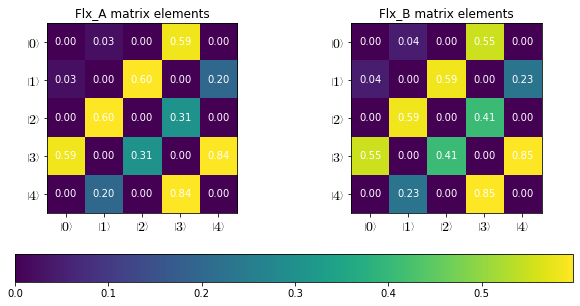

In [12]:
def plot_charge_op(flx, name, ax, vmin, vmax):
    lv = range(levels)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in lv]
    mat_elements = flx.mat_elements(operator='charge_op', levels=lv, as_xarray=True)

    
    im = ax.imshow(np.abs(mat_elements), cmap='viridis', vmin = vmin, vmax = vmax)

    for in_level, out_level in product(lv, repeat=2):
        amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
        ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")

    ax.set_xticks(lv)
    ax.set_yticks(lv)
    ax.set_xticklabels(level_labels, fontsize = 14)
    ax.set_yticklabels(level_labels, fontsize = 14)

#     cbar = plt.colorbar()
#     cbar.ax.set_ylabel(r"Amplitude $\hat{n}^{F}_{i \rightarrow f}$", rotation=-90, va="bottom")

    ax.set_title(name +  ' matrix elements')

    return im

vmin = min(np.min(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.min(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

vmax = max(np.max(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.max(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ima = plot_charge_op(flx_a, "Flx_A", ax[0], vmin, vmax)
imb = plot_charge_op(flx_b, "Flx_B", ax[1], vmin, vmax)

fig.colorbar(ima, ax=ax.ravel().tolist(), orientation = 'horizontal')

In [13]:
energies_in_lexico = np.zeros(levels**2, dtype=float)
count = 0
for k in range(0, levels):
    for m in range(0, levels):
        energies_in_lexico[count] = energies_b[m] + energies_a[k]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)

label_converter = ascending_to_lexico
label_converter

array([ 0,  5,  1,  6,  2,  7, 10, 11, 15, 16,  3,  8, 20, 21,  4,  9, 12,
       17, 13, 18, 22, 14, 23, 19, 24])

In [14]:
energies_in_lexico = np.zeros(levels**2, dtype=float)
count = 0
for k in range(0, levels):
    for m in range(0, levels):
        energies_in_lexico[count] = energies_b[m] + energies_a[k]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)

label_converter = ascending_to_lexico
label_converter

array([ 0,  5,  1,  6,  2,  7, 10, 11, 15, 16,  3,  8, 20, 21,  4,  9, 12,
       17, 13, 18, 22, 14, 23, 19, 24])

In [15]:
# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels: int,
    energies: np.ndarray,  #in ascending order
    label_converter: np.ndarray 
) -> float:
    label = k*levels + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray 
) -> float:
    label = k*levels + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return eig_states[index] 

def energy_ascending_order_to_label(
    k : int,
    levels: int,
    label_converter : np.ndarray):
    
    lexico_rank = label_converter[k]
    i = lexico_rank//levels
    j = lexico_rank%levels
    
    return i, j

# Coupled fluxonia

In [16]:
jc = 0.224 #GHz (divided by h)

coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_flx.eig_states() 

coupled_flx_bare = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_flx_bare.eig_states() 

## Drive

In [17]:
eig_states_by_label = []

for i_a in range(levels):
    eig_states_by_label.append([])
    for i_b in range(levels):
        eig_states_by_label[i_a].append(qtp.Qobj(inpt=  label_to_states(i_a, i_b, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels*levels, 1]))

In [18]:
n_a = qtp.tensor(flx_a.charge_op(as_qobj = True), qtp.qeye(flx_b.charge_op(as_qobj = True).dims[0]))
n_b = qtp.tensor(qtp.qeye(flx_a.charge_op(as_qobj = True).dims[0]), flx_b.charge_op(as_qobj = True))
n_charge = [n_a, n_b]

In [21]:
big_delta = ( label_to_energies(2, 1, levels, energies_sys, label_converter)   - \
              label_to_energies(1, 1, levels, energies_sys, label_converter) ) - \
            ( label_to_energies(2, 0, levels, energies_sys, label_converter)   - \
              label_to_energies(1, 0, levels, energies_sys, label_converter) )

display(Latex(r'$\Delta/2\pi $ = {:.3f} MHz'.format(big_delta*1000)))

<IPython.core.display.Latex object>

According to the paper we have :

$$\Omega_{11-21}  = \left| \epsilon_A \langle 11 | \hat{n}_A | 21 \rangle + \epsilon_B \langle 11 | \hat{n}_B | 21 \rangle \right|$$
$$\Omega_{10-20}  = \left| \epsilon_A \langle 10 | \hat{n}_A | 20 \rangle + \epsilon_B \langle 10 | \hat{n}_B | 20 \rangle \right|$$

And then :
$$r = \dfrac{\Omega_{11-21}}{\Omega_{10-20}} \text{  and  } \dfrac{\delta}{\Delta} = \dfrac{r^2 - \sqrt{(r^2-1)^2 + r^2 }} {r^2 - 1}$$ 

With these conventions taken in the paper :
$$\Delta = f_{11-21} - f_{10-20}$$
$$\delta = f_{11-21} - f_d$$

With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$. 

We choose as in the paper to have : $\dfrac{\epsilon_A}{\epsilon_B} = .9$

In [25]:
ratio_eps = .9

We now match the conditions

In [26]:
def Omega1(eps_b, ratio_eps):
    eps_a = eps_b*ratio_eps
    eps = [eps_a, eps_b]
    
    rabi_10_20 = np.abs(eps[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[2][0]).full()[0, 0] + \
                              eps[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[2][0]).full()[0, 0] )
    rabi_11_21 = np.abs(eps[0] * (eig_states_by_label[1][1].dag() * n_charge[0] * eig_states_by_label[2][1]).full()[0, 0] + \
                              eps[1] * (eig_states_by_label[1][1].dag() * n_charge[1] * eig_states_by_label[2][1]).full()[0, 0] )

    rabi_ratio = rabi_11_21/rabi_10_20
    ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
    
    big_delta = ( label_to_energies(2, 1, levels, energies_sys, label_converter)   - \
                  label_to_energies(1, 1, levels, energies_sys, label_converter) ) - \
                ( label_to_energies(2, 0, levels, energies_sys, label_converter)   - \
                  label_to_energies(1, 0, levels, energies_sys, label_converter) )
    small_delta = big_delta * ratio_delta
    
    return np.sqrt(rabi_11_21**2 + small_delta**2)

def Omega2(eps_b, ratio_eps):
    eps_a = eps_b*ratio_eps
    eps = [eps_a, eps_b]
        
    rabi_10_20 = np.abs(eps[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[2][0]).full()[0, 0] + \
                              eps[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[2][0]).full()[0, 0] )
    rabi_11_21 = np.abs(eps[0] * (eig_states_by_label[1][1].dag() * n_charge[0] * eig_states_by_label[2][1]).full()[0, 0] + \
                              eps[1] * (eig_states_by_label[1][1].dag() * n_charge[1] * eig_states_by_label[2][1]).full()[0, 0] )

    rabi_ratio = rabi_11_21/rabi_10_20
    ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
    
    big_delta = ( label_to_energies(2, 1, levels, energies_sys, label_converter)   - \
                  label_to_energies(1, 1, levels, energies_sys, label_converter) ) - \
                ( label_to_energies(2, 0, levels, energies_sys, label_converter)   - \
                  label_to_energies(1, 0, levels, energies_sys, label_converter) )
    small_delta = big_delta * ratio_delta
    
    return np.sqrt(rabi_10_20**2 + (small_delta - big_delta)**2)

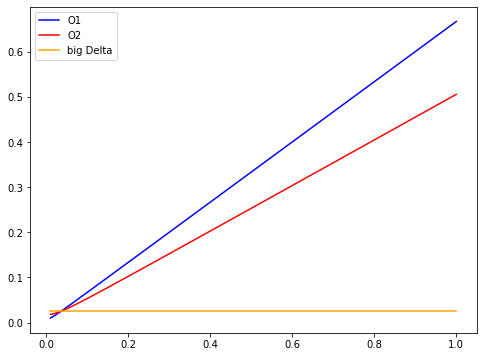

In [31]:
rg_e_b = np.linspace(0.01, 1, 1000)

plt.figure(figsize=(8, 6))
plt.plot(rg_e_b, Omega1(rg_e_b, ratio_eps), color = 'blue', label = 'O1')
plt.plot(rg_e_b, Omega2(rg_e_b, ratio_eps), color = 'red', label = 'O2')
plt.plot(rg_e_b, [big_delta]*len(rg_e_b), color = 'orange', label = 'big Delta')

plt.legend()
plt.show()

## Rest of parameters

In [45]:
eps_b = 0.03634
eps_a = ratio_eps*eps_b
eps = [eps_a, eps_b]

In [46]:
#we calculate rabi freq amplitudes :

rabi_10_20 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[2][0]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[2][0]).full()[0, 0] )

rabi_11_21 = np.abs(eta[0] * (eig_states_by_label[1][1].dag() * n_charge[0] * eig_states_by_label[2][1]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][1].dag() * n_charge[1] * eig_states_by_label[2][1]).full()[0, 0] )

rabi_ratio = rabi_11_21/rabi_10_20
display(Latex(r'$r$ = {:.3f}'.format(rabi_ratio)))

ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
display(Latex(r'$\delta/\Delta$ = {:.3f}'.format(ratio_delta)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [51]:
small_delta = big_delta*ratio_delta

freq_drive = ( label_to_energies(2, 1, levels, energies_sys, label_converter)   - \
               label_to_energies(1, 1, levels, energies_sys, label_converter) )  - small_delta
t_drive = 1/big_delta

display(Latex(r'$\Delta/2\pi $ = {:.3f} MHz'.format(big_delta*1000)))
display(Latex(r'$\delta/2\pi $ = {:.3f} MHz'.format(small_delta*1000)))
display(Latex(r'$\omega_d/2\pi $ = {:.3f} GHz'.format(freq_drive)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [62]:
rabi_freq = big_delta

rabi_period = 1/rabi_freq # [ns]
display(Latex(r'$T_{{Rabi}} $ = {:.3f} ns'.format(rabi_period)))

<IPython.core.display.Latex object>

#  Simulations

In [137]:
#AC: remark. I am starting to think that the pulse is nor correctly implemented
# In fact it is discontinuous at t = rise_time which is not possible. To make it continuous
# at the plateau one should set the amplitude not to be one, but (1 - exp(-rise_time)**2(2*sigma**2))
# In the paper this is a bit confusing I would say.

def pulse_function(
    t: float,
    rise_time: float,
    plateau_time: float,
    freq_drive: float
) -> float:
    sigma = rise_time/np.sqrt(2*np.pi)
    flat_amplitude = (1 - np.exp(-rise_time**2/(2*sigma**2)))
    if t < rise_time:
        return 1/flat_amplitude*(np.exp(-(t - rise_time)**2/(2*sigma**2)) - \
                                 np.exp(-rise_time**2/(2*sigma**2)))*np.cos(2*np.pi*freq_drive*t)
    elif t < rise_time + plateau_time:
        return np.cos(2*np.pi*freq_drive*t)
    else:
        return 1/flat_amplitude*(np.exp(-(t - plateau_time - rise_time)**2/(2*sigma**2)) - \
                          np.exp(-rise_time**2/(2*sigma**2)))*np.cos(2*np.pi*freq_drive*t)

In [138]:
t_rise = 17.6
t_tot = 58.3
t_plateau = t_tot - 2*t_rise
#simulation setup (noiseless)
pts_per_drive_period = 15
simu_time = t_tot

nb_points = int( simu_time * freq_drive * pts_per_drive_period  )
tlist = np.linspace(0, simu_time, nb_points)
pulse_drive = np.zeros(nb_points, dtype=float)

interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]]
labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in interest_levels]

hamil0 = coupled_flx.hamiltonian(as_qobj=True)
hamil_drive = eta[0]*n_charge[0] + eta[1]*n_charge[1] 

for i in range(0, nb_points):
    pulse_drive[i] = pulse_function(tlist[i], t_rise, t_plateau, freq_drive)

In [155]:
outputs = []
for i in range(0, 2):
    for k in range(0, 2):
        state_in = eig_states_by_label[i][k]
        outputs.append(solvkit.integrate(tlist*2*np.pi, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve"))

In [161]:
statein_index = 3
rhos_by_label = []
for i in range(len(eig_states_by_label)):
    rhos_by_label.append([])
    for j in range(len(eig_states_by_label[0])):
        rhos_by_label[i].append(eig_states_by_label[i][j]*eig_states_by_label[i][j].dag())  
        
probs = np.zeros([len(labels), nb_points], dtype=float)
for k in range(0, len(labels)):
    i, j = interest_levels[k]
    for m in range(0, nb_points):        
        probs[k, m] = qtp.expect(rhos_by_label[i][j], outputs[statein_index].states[m]) 

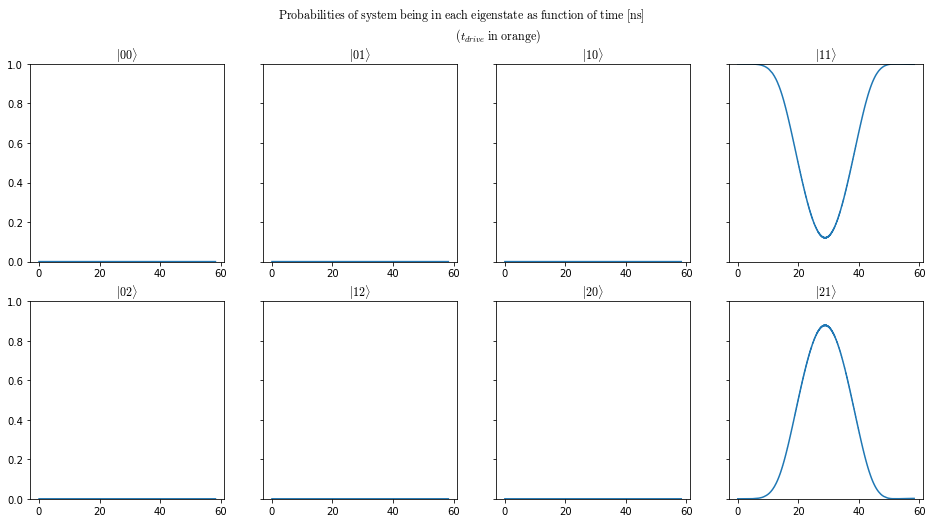

In [162]:
def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray
) -> None:
    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = (16, 8))
    for k in range(0, len(labels)):
        ax[k//4, k%4].plot(tlist, probs[k, :])

        ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title(labels[k])

        if k%4 != 0:
            ax[k//4, k%4].axes.yaxis.set_ticklabels([])

    fig = plt.gcf()
    fig.suptitle('$\mathrm{Probabilities \ of \ system \ being \ in  \ \
                 each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
                 $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
    return 

plot_probas(tlist, probs)